# MRIS Heuristics

- Sweep over the number of jobs for the Azure packing 2020 dataset
- 20 machines
- 4 resources
- We fix the total number of jobs (4.096M jobs)
- For each run of $N$, we evenly subsample a subset of this total number
- This looks at jobs with $r_\text{max} = 12.5$

Schedulers:
```
schedulers = [
        MRIS(sort='WSVF'),
        MRIS(sort='SVF'),
        MRIS(sort='WSDF'),
        MRIS(sort='SDF'),
        MRIS(sort='WSJF'),
        MRIS(sort='SJF'),
        MRIS(sort='ERF')
]
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
from pathlib import Path
import itertools
import scipy.stats as st

In [2]:
plt.style.use(['science'])
params = {
    "font.family": "serif",
    "text.usetex": True,
    'text.latex.preamble':
        r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
}
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
def get_linestyles():
     return itertools.cycle([
         ('solid', (0, ())),
         # ('loosely dotted',        (0, (1, 10))),
         ('dotted',                (0, (1, 1))),
         # ('densely dotted',        (0, (1, 1))),
         ('long dash with offset', (5, (10, 3))),
         ('loosely dashed',        (0, (5, 10))),
         #('dashed',                (0, (5, 5))),
         ('densely dashed',        (0, (5, 1))),
    
         #('loosely dashdotted',    (0, (3, 10, 1, 10))),
         ('dashdotted',            (0, (3, 5, 1, 5))),
         ('densely dashdotted',    (0, (3, 1, 1, 1))),
    
         ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
         ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
         ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
    ])
mpl.rcParams.update(params)

# Input Parameters

In [3]:
N = 4_096_000

# This defines the downsample factors used in the simulation
DOWNSAMPLE_FACTORS = np.array([1024, 512, 256, 128, 64])

# Number of runs per downsample factor (each factor must have the same number of runs)
NUM_RUNS = 10

# Path to the results folder
PATH_TO_RESULTS = Path('./results/')

In [4]:
N_arr = (N / DOWNSAMPLE_FACTORS).astype(int) # The number of jobs processed
print(N_arr)

[ 4000  8000 16000 32000 64000]


# Plot AWCT

In [5]:
awct_data = {}
for i, downsample_factor in enumerate(DOWNSAMPLE_FACTORS):
    for run in range(1, NUM_RUNS + 1):
        data = pd.read_parquet(PATH_TO_RESULTS / Path(f'1_MRIS_heuristics_{downsample_factor}_{run}.parquet'))
        schedulers = list(data['scheduler'].unique())
        for scheduler in schedulers:
            df = data[data['scheduler'] == scheduler]
            weighted_completion_time = df['C'].dot(df['w']) / len(df)
            vals = awct_data.get(scheduler, np.zeros(shape=(len(DOWNSAMPLE_FACTORS), NUM_RUNS)).astype(float))
            vals[i][run-1] = weighted_completion_time
            awct_data[scheduler] = vals

In [6]:
awct_x = {scheduler:np.mean(data, axis=1) for scheduler, data in awct_data.items()}
# 95 % Confidence Intervals
awct_error = {scheduler:st.t.interval(0.95, df=data.shape[1]-1, loc=np.mean(data, axis=1), scale=st.sem(data, axis=1)) for scheduler, data in awct_data.items()}

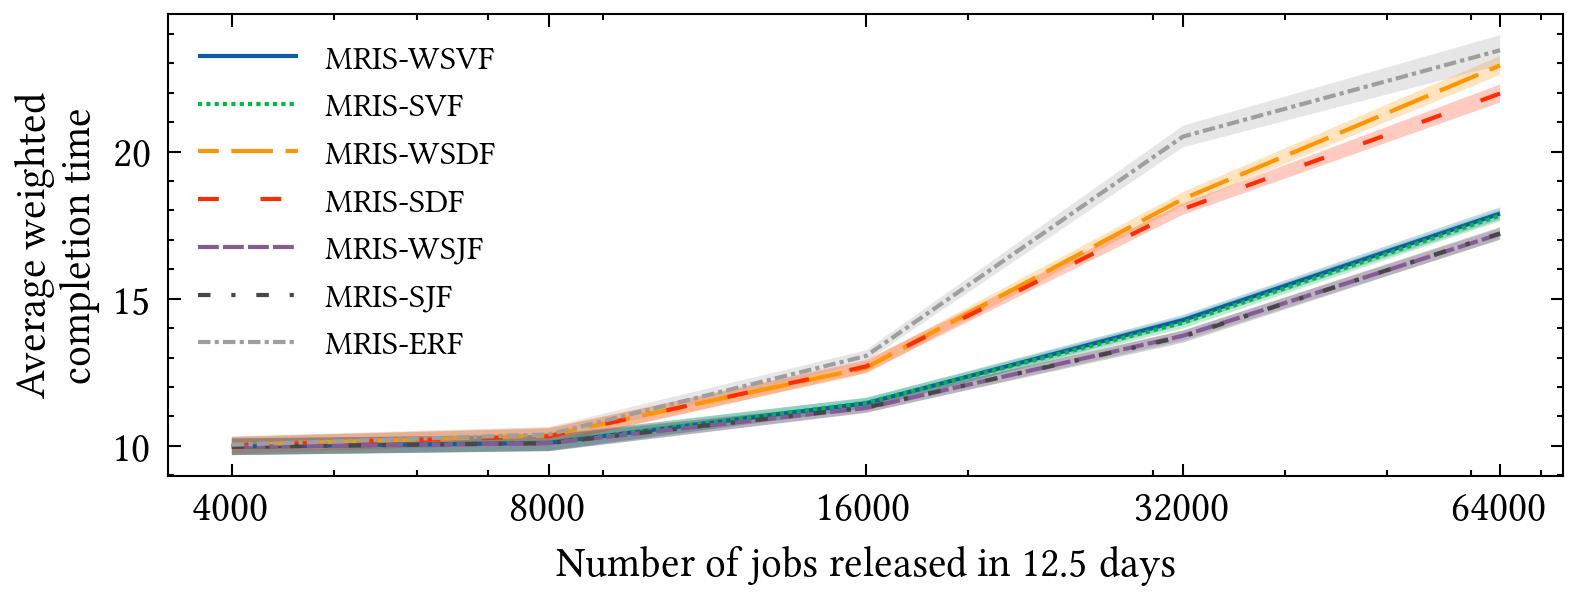

In [9]:
plt.figure(figsize=(6, 2), dpi=300)

N_thousands = (N_arr / 1000).astype(float)
linestyles = get_linestyles()
for scheduler, weighted_completion_times in awct_x.items():
    plt.plot(N_arr, weighted_completion_times, label=scheduler, linestyle=next(linestyles)[1])
    plt.fill_between(N_arr, awct_error[scheduler][0], awct_error[scheduler][1], alpha=0.25)
plt.xscale('log')
plt.xticks(N_arr, N_arr)
# plt.yscale('log', base=2)
plt.ylabel("Average weighted\n completion time")
plt.xlabel(r"Number of jobs released in 12.5 days")
plt.legend(prop={'size': 8}, handlelength=3, ncol=1)
plt.savefig('sorting.pdf', bbox_inches='tight')
plt.show()